In [1]:
import os, cv2, random
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import tifffile as tiff

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.model_selection import train_test_split


In [2]:
!unzip "/content/drive/MyDrive/Computer Vision Tasks - Cellula/week 3/data-20250919T092629Z-1-001.zip" -d "/content/"

Archive:  /content/drive/MyDrive/Computer Vision Tasks - Cellula/week 3/data-20250919T092629Z-1-001.zip
  inflating: /content/data/images/2.tif  
  inflating: /content/data/images/303.tif  
  inflating: /content/data/images/302.tif  
  inflating: /content/data/images/301.tif  
  inflating: /content/data/images/304.tif  
  inflating: /content/data/images/305.tif  
  inflating: /content/data/images/298.tif  
  inflating: /content/data/images/297.tif  
  inflating: /content/data/images/300.tif  
  inflating: /content/data/images/294.tif  
  inflating: /content/data/images/296.tif  
  inflating: /content/data/images/295.tif  
  inflating: /content/data/images/299.tif  
  inflating: /content/data/images/292.tif  
  inflating: /content/data/images/291.tif  
  inflating: /content/data/images/289.tif  
  inflating: /content/data/images/287.tif  
  inflating: /content/data/images/293.tif  
  inflating: /content/data/images/288.tif  
  inflating: /content/data/images/290.tif  
  inflating: /cont

In [3]:
train_img_dir = "/content/data/images"
train_mask_dir = "/content/data/labels"

In [4]:
image_extensions = set()
for file in os.listdir(train_img_dir):
   image_extensions.add(file.split('.')[-1])
print(image_extensions)

{'tif'}


In [5]:
mask_extensions_2 = set()
for file in os.listdir(train_mask_dir):
   mask_extensions_2.add(file.split('.')[-1])
print(mask_extensions_2)

{'png'}


Selected: 257.tif
Image shape: (128, 128, 12)
Mask shape: (128, 128)


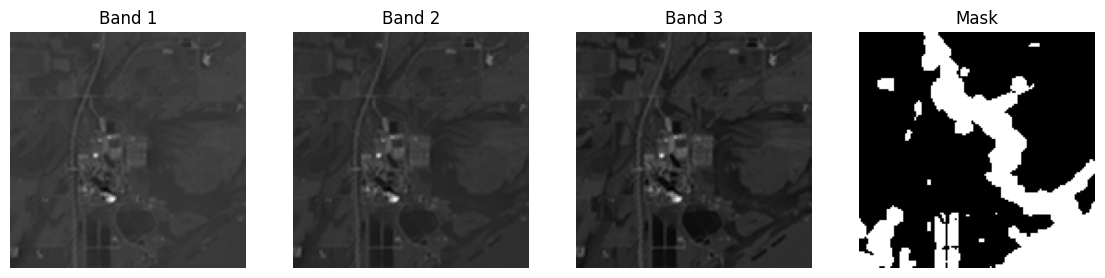

In [6]:
def display_image_and_mask(img_path, mask_path):
    img = tiff.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    print("Image shape:", img.shape)
    print("Mask shape:", mask.shape)

    # عرض 3 باندات + الماسك
    fig, axes = plt.subplots(1, 4, figsize=(14, 4))
    axes[0].imshow(img[:,:,0], cmap="gray")
    axes[0].set_title("Band 1")
    axes[0].axis("off")

    axes[1].imshow(img[:,:,1], cmap="gray")
    axes[1].set_title("Band 2")
    axes[1].axis("off")

    axes[2].imshow(img[:,:,2], cmap="gray")
    axes[2].set_title("Band 3")
    axes[2].axis("off")

    axes[3].imshow(mask, cmap="gray")
    axes[3].set_title("Mask")
    axes[3].axis("off")

    plt.show()


random_name = random.choice(os.listdir(train_img_dir))
img_path = os.path.join(train_img_dir, random_name)
mask_name = random_name.replace(".tif", ".png")
mask_path = os.path.join(train_mask_dir, mask_name)

print("Selected:", random_name)
display_image_and_mask(img_path, mask_path)


In [7]:
image_files = [f.replace(".tif", "") for f in os.listdir(train_img_dir) if f.endswith(".tif")]
mask_files  = [f.replace(".png", "") for f in os.listdir(train_mask_dir) if f.endswith(".png")]

common_files = sorted(list(set(image_files).intersection(set(mask_files))))

print("Total images:", len(image_files))
print("Total masks:", len(mask_files))
print("Matched pairs:", len(common_files))

images = [os.path.join(train_img_dir, f + ".tif") for f in common_files]
masks  = [os.path.join(train_mask_dir, f + ".png") for f in common_files]

data = pd.DataFrame({"image": images, "mask": masks})
print(data.head())

train_df, val_df = train_test_split(data, train_size=0.8, shuffle=True, random_state=42)


Total images: 306
Total masks: 456
Matched pairs: 306
                          image                          mask
0    /content/data/images/0.tif    /content/data/labels/0.png
1    /content/data/images/1.tif    /content/data/labels/1.png
2   /content/data/images/10.tif   /content/data/labels/10.png
3  /content/data/images/100.tif  /content/data/labels/100.png
4  /content/data/images/101.tif  /content/data/labels/101.png


In [8]:
def load_image(img_path):
    # اقرأ الـ 12 باند
    img = tiff.imread(img_path).astype("float32")
    img = img / 255.0   # Normalization
    return img

def load_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 0).astype("float32")
    mask = np.expand_dims(mask, axis=-1)  # (128,128,1)
    return mask

def data_generator(df, batch_size=16):
    while True:
        batch = df.sample(batch_size)
        imgs, masks = [], []
        for _, row in batch.iterrows():
            img = load_image(row["image"])
            mask = load_mask(row["mask"])
            imgs.append(img)
            masks.append(mask)
        yield np.array(imgs), np.array(masks)


In [9]:
train_generator = data_generator(train_df, batch_size=16)
val_generator = data_generator(val_df, batch_size=16)


In [10]:
def unet_model(input_size=(128,128,12)):
    inputs = Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)

    c5 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

model = unet_model(input_size=(128,128,12))
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=len(train_df)//16,
    validation_steps=len(val_df)//16
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7720 - loss: 0.4986 - val_accuracy: 0.8823 - val_loss: 0.3570
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 734ms/step - accuracy: 0.8696 - loss: 0.3620 - val_accuracy: 0.8925 - val_loss: 0.3248
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.8910 - loss: 0.3182 - val_accuracy: 0.9073 - val_loss: 0.2760
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - accuracy: 0.8874 - loss: 0.3043 - val_accuracy: 0.9017 - val_loss: 0.2896
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.8727 - loss: 0.3054 - val_accuracy: 0.9096 - val_loss: 0.2564
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.8950 - loss: 0.2604 - val_accuracy: 0.9138 - val_loss: 0.2516
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - accuracy: 0.8984 - loss: 0.2705 - val_accuracy: 0.9270 - val_loss: 0.2128
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 350ms/step - accuracy: 0.8997 - loss: 0.2591 - val_accuracy: 0.9

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


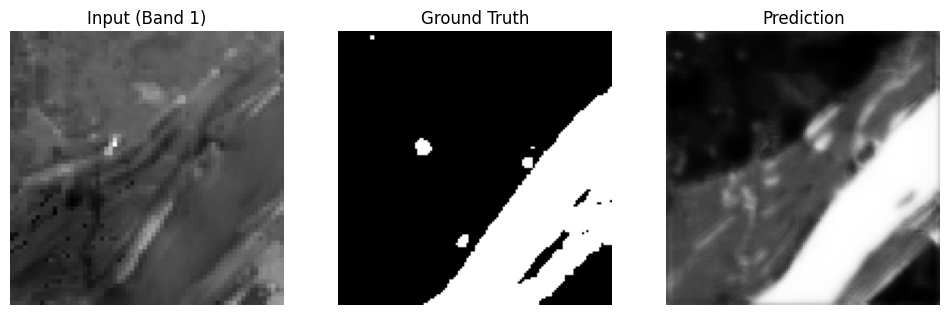

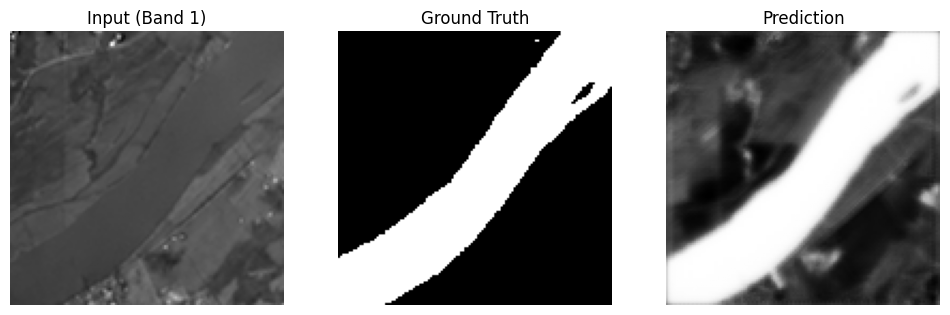

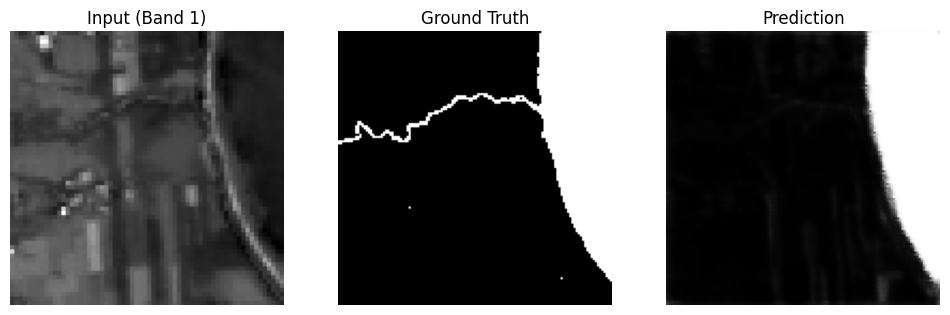

In [14]:
#  Visualization of predictions
imgs, masks = next(val_generator)
preds = model.predict(imgs)

for i in range(3):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(imgs[i][:,:,0], cmap="gray")  # Band 1 only
    plt.title("Input (Band 1)")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(masks[i].squeeze(), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(preds[i].squeeze(), cmap="gray")
    plt.title("Prediction")
    plt.axis("off")
    plt.show()